In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import SplineTransformer, QuantileTransformer, RobustScaler, PolynomialFeatures, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder

import mlflow
from dotenv import load_dotenv

load_dotenv()


# определяем основные credentials, которые нужны для подключения к MLflow
# важно, что credentials мы передаём для себя как пользователей Tracking Service
# у вас должен быть доступ к бакету, в который вы будете складывать артефакты
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env

# определяем глобальные переменные
# поднимаем MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

YOUR_NAME = "merka" # введите своё имя для создания уникального эксперимента
assert YOUR_NAME, "введите своё имя в переменной YOUR_NAME для создания уникального эксперимента"

# название тестового эксперимента и запуска (run) внутри него
EXPERIMENT_NAME = f"test_connection_experiment_{YOUR_NAME}"
RUN_NAME = "test_connection_run"

# тестовые данные
METRIC_NAME = "test_metric"
METRIC_VALUE = 0

# устанавливаем host, который будет отслеживать наши эксперименты
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [ ]:
# создаём тестовый эксперимент и записываем в него тестовую информацию
experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metric(METRIC_NAME, METRIC_VALUE)

In [7]:
#### 4. Проверяем себя, что в MLflow:
# - создался `experiment` с нашим именем
# - внутри эксперимента появился запуск `run`
# - внутри `run` записалась наша тестовая `metric`
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
run = mlflow.get_run(run_id)

assert "active" == experiment.lifecycle_stage
assert mlflow.get_run(run_id)
assert METRIC_VALUE == run.data.metrics[METRIC_NAME] 

In [8]:
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metric(METRIC_NAME, METRIC_VALUE)

In [14]:
import os

import mlflow
from dotenv import load_dotenv

load_dotenv()

# определяем основные credentials, которые нужны для подключения к MLflow
# важно, что credentials мы передаём для себя как пользователей Tracking Service
# у вас должен быть доступ к бакету, в который вы будете складывать артефакты
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env

# определяем глобальные переменные
# поднимаем MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

YOUR_NAME = "merkam" # введите своё имя для создания уникального эксперимента
assert YOUR_NAME, "введите своё имя в переменной YOUR_NAME для создания уникального эксперимента"

# название тестового эксперимента и запуска (run) внутри него
EXPERIMENT_NAME = f"test_connection_experiment_{YOUR_NAME}"
RUN_NAME = "test_connection_run"

# тестовые данные
METRIC_NAME = "test_metric"
METRIC_VALUE = 0

# устанавливаем host, который будет отслеживать наши эксперименты
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

# создаём тестовый эксперимент и записываем в него тестовую информацию
experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

#experiment_id = '1'

# указываем путь до окружения
pip_requirements="requirements.txt"

class MyModel(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        # Загружаем модель, например, из pickle
        model_path = "mlflow_experiments_store/models/fitted_model.pkl"
        with open(model_path, "rb") as f:
            self.model = pickle.load(f)
    
    def predict(self, context, model_input):
        # Сделать предсказание на основе загруженной модели
        return self.model.predict(model_input)

# формируем сигнатуру, дополнительно передавая параметры применения модели
signature = mlflow.models.infer_signature(
	np.array([[0.1, 0.2, 0.3], [0.1, 0.2, 0.3]]),
	np.array([0.1, 0.2])
)
# формируем пример входных данных
input_example = [[0.1, 0.2, 0.3], [0.1, 0.2, 0.3]]
# предположим, мы хотим указать на то, что модель предсказывает на месяц вперёд
metadata = {"target_name": "churn"}
# путь до скрипта или ноутбука, который осуществляет обучение модели и валидацию
code_paths = ["train.py", "val_model.py"]

with mlflow.start_run(run_name="model_reg", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
  
    model_info = mlflow.pyfunc.log_model( 
		#registered_model_name=REGISTRY_MODEL_NAME,
        pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example,
        metadata=metadata,
       # code_paths=code_paths,
        python_model=MyModel(),
        artifact_path='models'
		)

In [11]:
from sqlalchemy import create_engine

# Считываем все креды
src_host = os.environ.get('DB_SOURCE_HOST')
src_port = os.environ.get('DB_SOURCE_PORT')
src_username = os.environ.get('DB_SOURCE_USER')
src_password = os.environ.get('DB_SOURCE_PASSWORD')
src_db = os.environ.get('DB_SOURCE_NAME') 

dst_host = os.environ.get('DB_DESTINATION_HOST')
dst_port = os.environ.get('DB_DESTINATION_PORT')
dst_username = os.environ.get('DB_DESTINATION_USER')
dst_password = os.environ.get('DB_DESTINATION_PASSWORD')
dst_db = os.environ.get('DB_DESTINATION_NAME')

s3_bucket = os.environ.get('S3_BUCKET_NAME')
s3_access_key = os.environ.get('AWS_ACCESS_KEY_ID')
s3_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

src_conn = create_engine(f'postgresql://{src_username}:{src_password}@{src_host}:{src_port}/{src_db}')
dst_conn = create_engine(f'postgresql://{dst_username}:{dst_password}@{dst_host}:{dst_port}/{dst_db}')

SQL = """SELECT *
FROM pg_catalog.pg_tables --каталог таблиц
where tableowner != 'postgres' --исключая административные таблицы"""

SQL1 = '''
    select artifact_uri from runs
            where run_uuid = '1d3fff2b7596404aaf79fc4207baa251'
    limit 10;
'''
display(pd.read_sql(SQL1, dst_conn))
display(pd.read_sql(SQL, dst_conn))

,artifact_uri
0,s3://s3-student-mle-20241121-3b865ccfbc/5/1d3f...


,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity
0,public,salaries,mle_20241121_3b865ccfbc,None,True,False,False,False
1,public,clean_users_churn,mle_20241121_3b865ccfbc,None,True,False,False,False
2,public,registered_model_aliases,mle_20241121_3b865ccfbc,None,True,False,True,False
3,public,datasets,mle_20241121_3b865ccfbc,None,True,False,True,False
4,public,inputs,mle_20241121_3b865ccfbc,None,True,False,False,False
5,public,input_tags,mle_20241121_3b865ccfbc,None,True,False,False,False
6,public,users_churn,mle_20241121_3b865ccfbc,None,True,False,False,False
7,public,buildings,mle_20241121_3b865ccfbc,None,True,False,False,False
8,public,flats,mle_20241121_3b865ccfbc,None,True,False,False,False
9,public,buildings_flats_table_clean,mle_20241121_3b865ccfbc,None,True,False,False,False


In [ ]:
import psycopg

import mlflow

EXPERIMENT_NAME = "test_connection_experiment_merk" # название эксперимента
RUN_NAME = "preprocessing" 
REGISTRY_MODEL_NAME = "Test"# название зарегистрированной модели 
TABLE_NAME = "users_churn"

connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)


obj_df = df.select_dtypes(include="object")
# определение категориальных колонок, которые будут преобразованы
cat_columns = ["type", "payment_method", "internet_service", "gender"]

# создание объекта OneHotEncoder для преобразования категориальных переменных
# auto - автоматическое определение категорий
# ignore - игнорировать ошибки, если встречается неизвестная категория
# max_categories - максимальное количество уникальных категорий
# sparse_output - вывод в виде разреженной матрицы, если False, то в виде обычного массива
# drop="first" - удаляет первую категорию, чтобы избежать ловушки мультиколлинеарности

encoder_oh = OneHotEncoder(categories='auto', handle_unknown='ignore', max_categories=10, sparse_output=False, drop='first')

# применение OneHotEncoder к данным. Преобразование категориальных данных в массив
encoded_features = encoder_oh.fit_transform(df[cat_columns].to_numpy())

# преобразование полученных признаков в DataFrame и установка названий колонок
encoded_df = pd.DataFrame(encoded_features, columns=encoder_oh.get_feature_names_out(cat_columns))

# конкатенация исходного DataFrame с новым DataFrame, содержащим закодированные категориальные признаки
obj_df = pd.concat([obj_df, encoded_df], axis=1)
#######################


# Числовые трансформеры
numeric_transformer = ColumnTransformer(transformers=[('spl', encoder_spl, num_columns), ('q', encoder_q, num_columns), ('rb', encoder_rb, num_columns), ('pol', encoder_pol, num_columns), ('kbd', encoder_kbd, num_columns)])

# Категориальные трансформеры
categorical_transformer = Pipeline(steps=[('encoder', encoder_oh)])

# Объединение числовых и категориальных преобразований
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_columns), ('cat', categorical_transformer, cat_columns)], n_jobs=-1)

# Применение преобразований к данным
encoded_features = preprocessor.fit_transform(df)

# Получение имён новых столбцов
numeric_columns = (
    ['monthly_charges_spl_0', 'monthly_charges_spl_1', 'monthly_charges_spl_2', 'monthly_charges_spl_3']
    + [col + f"_q_{100}" for col in num_columns]  # Названия для трансформированных числовых признаков
    + [col + f"_robust" for col in num_columns]
    + [col + f"_poly_{i}" for i in range(1, 10)]  # Учитывая, что degree=3, будет 9 признаков
    + [col + f"_bin" for col in num_columns]
)

categorical_columns = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_columns)

# Объединение новых признаков с исходным DataFrame
transformed_df = pd.DataFrame(encoded_features, columns=preprocessor.get_feature_names_out())

# Добавление преобразованных признаков в исходный DataFrame
df = pd.concat([df, transformed_df], axis=1)


#######################



In [13]:
preprocessor = ColumnTransformer(transformers=None)
experiment_id = mlflow.get_experiment_by_name("test_connection_experiment_merkam").experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.sklearn.log_model(preprocessor, "column_transformer") 

2025/01/05 18:55:52 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [1]:
import pandas as pd
import numpy as np

# Создание DataFrame
data = {'A': [1, 2, 3, 4, 5]}
df = pd.DataFrame(data)

# пользовательская функция для возведения в квадрат
def square_value(x):
    return x ** 2

# применение np.vectorize к df["A"] с пользовательской функцией
vectorized_func = np.vectorize(square_value)
result_custom = vectorized_func(df["A"])

print("Vectorized with custom function:")
print(result_custom)

# применение np.square к df["A"]
result_np_square = np.square(df["A"])

print("\nVectorized with numpy square:")
print(result_np_square)

Vectorized with custom function:
[ 1  4  9 16 25]

Vectorized with numpy square:
0     1
1     4
2     9
3    16
4    25
Name: A, dtype: int64


In [15]:
from autofeat import AutoFeatRegressor
from sklearn.model_selection import train_test_split


# Загрузка данных
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Напишите код ниже #
# auto_feat = AutoFeatRegressor(
#     max_gb = 16,
#     transformations = ["1+", "log", "abs", "sqrt"],
#     feateng_steps = 2
    
# )

# X_train_transformed = auto_feat.fit_transform(X_train, y_train)
# X_test_transformed = auto_feat.transform(X_test)





transformations = ('1/', 'log', 'abs', 'sqrt')# ваш код здесь #

afc = AutoFeatRegressor(
    #categorical_cols=cat_features,
    transformations = transformations,
    feateng_steps = 1,
    max_gb = 16,
    n_jobs=-1
    
)# ваш код здесь # автоэнкодер признаков

X_train_features = afc.fit_transform(X_train, y_train)# ваш код здесь # примените автоэнкодер признаков для данных для обучения
X_test_features = afc.transform(X_test)# ваш код здесь # примените автоэнкодер признаков для данных для валидации/теста


artifact_path = "afc"
experiment_id = mlflow.create_experiment("your experiment name")
#experiment_id = mlflow.get_experiment_by_name("your experiment name").experiment_id

with mlflow.start_run(run_name="your run name", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    afc_info = mlflow.sklearn.log_model(afc, artifact_path=artifact_path)

NameError: name 'np' is not defined

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_features, y_train)



LinearRegression()

In [8]:
mlflow.sklearn.log_model(model, artifact_path=artifact_path, registered_model_name="your experiment model name")

Registered model 'your experiment model name' already exists. Creating a new version of this model...
2025/01/07 14:16:45 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: your experiment model name, version 2
Created version '2' of model 'your experiment model name'.


In [3]:
import os
from sklearn.model_selection import train_test_split
import psycopg
import pandas as pd
import mlflow
from catboost import CatBoostClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv
load_dotenv()

# Считываем все креды
src_host = os.environ.get('DB_SOURCE_HOST')
src_port = os.environ.get('DB_SOURCE_PORT')
src_username = os.environ.get('DB_SOURCE_USER')
src_password = os.environ.get('DB_SOURCE_PASSWORD')
src_db = os.environ.get('DB_SOURCE_NAME') 

dst_host = os.environ.get('DB_DESTINATION_HOST')
dst_port = os.environ.get('DB_DESTINATION_PORT')
dst_username = os.environ.get('DB_DESTINATION_USER')
dst_password = os.environ.get('DB_DESTINATION_PASSWORD')
dst_db = os.environ.get('DB_DESTINATION_NAME')

s3_bucket = os.environ.get('S3_BUCKET_NAME')
s3_access_key = os.environ.get('AWS_ACCESS_KEY_ID')
s3_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

dst_conn = create_engine(f'postgresql://{dst_username}:{dst_password}@{dst_host}:{dst_port}/{dst_db}')

TABLE_NAME = "kind_of_cleaned_users_churn"
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME_SFS = "Feature_selection_plots_SFS2"
RUN_NAME = "feature_selection"
REGISTRY_MODEL_NAME = "VOPROS"
FS_ASSETS = "fs_assets"


os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")




In [5]:
SQL = f"select * from {TABLE_NAME}"
data = pd.read_sql(SQL, dst_conn)
df = data
display(data)

y = df['multiple_lines_Yes'] #костыль вместо target
X = df.drop(columns=['multiple_lines_Yes'])  # Признаки


# display(y)
# display(X)
# 1. Разделяем данные на обучающую (70%) и тестовую (30%) выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Теперь разделим обучающую выборку на обучающую (70% от 70% = 49% от всей выборки) и валидационную (30% от 70% = 21% от всей выборки)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# # Печатаем размеры выборок
# print(f"Размер обучающей выборки: {X_train.shape[0]} примеров")
# print(f"Размер валидационной выборки: {X_val.shape[0]} примеров")
# print(f"Размер тестовой выборки: {X_test.shape[0]} примеров")
#display(X_train)


# Создаем оценщик случайного леса
estimator = RandomForestClassifier(n_estimators=300)

# Sequential Forward Selection (SFS)
sfs = SFS(estimator, k_features=2, forward=True, floating=False, scoring='roc_auc', cv=2, n_jobs=-1)

# Запускаем отбор признаков для SFS
sfs = sfs.fit(X_train, y_train)


,paperless_billing_Yes,internet_service_Fiber optic,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,gender_Male,partner_Yes,dependents_Yes,multiple_lines_Yes
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
7039,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7040,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
7041,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [29]:
# Sequential Backward Selection (SBS)
sbs = SFS(estimator, k_features=2, forward=False, floating=False, scoring='roc_auc', cv=2, n_jobs=-1)

# Запускаем отбор признаков для SBS
sbs = sbs.fit(X_train, y_train)

# Сохраняем имена выбранных признаков
top_sfs = sfs.k_feature_names_
top_sbs = sbs.k_feature_names_

# Выводим результаты
print('\nSequential Forward Selection (k=10)')
print('CV Score:', sfs.k_score_)

print('\nSequential Backward Selection')
print('CV Score:', sbs.k_score_)

print('\nTop Features from SFS:', top_sfs)
print('Top Features from SBS:', top_sbs)


Sequential Forward Selection (k=10)
CV Score: 0.6982944063592854

Sequential Backward Selection
CV Score: 0.6753610162544311

Top Features from SFS: ('paperless_billing_Yes', 'internet_service_Fiber optic', 'online_backup_Yes', 'device_protection_Yes', 'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes', 'gender_Male', 'partner_Yes', 'dependents_Yes')
Top Features from SBS: ('internet_service_Fiber optic', 'streaming_movies_Yes')


In [ ]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 

display(sfs_df)
display(sbs_df)

os.mkdir(FS_ASSETS)

sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv") 




,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)","[0.6451866846603689, 0.607279220565485, 0.6093...",0.622947,"(streaming_tv_Yes,)",0.025025,0.015611,0.009013
2,"(1, 6)","[0.6747473750041144, 0.6551627662025608, 0.649...",0.670202,"(internet_service_Fiber optic, streaming_tv_Yes)",0.032918,0.020536,0.011856
3,"(1, 4, 6)","[0.7092481046267952, 0.7018229595251418, 0.683...",0.704733,"(internet_service_Fiber optic, device_protecti...",0.023838,0.014871,0.008586
4,"(1, 3, 4, 6)","[0.7285200179937023, 0.7123695730884434, 0.699...",0.721951,"(internet_service_Fiber optic, online_backup_Y...",0.028826,0.017982,0.010382
5,"(0, 1, 3, 4, 6)","[0.7302755011355782, 0.7201650154153364, 0.711...",0.726644,"(paperless_billing_Yes, internet_service_Fiber...",0.019592,0.012222,0.007057
6,"(0, 1, 3, 4, 6, 8)","[0.7317045741307615, 0.7178719155612608, 0.715...",0.727846,"(paperless_billing_Yes, internet_service_Fiber...",0.020189,0.012594,0.007271
7,"(0, 1, 3, 4, 6, 8, 9)","[0.738038028153561, 0.713436577685615, 0.70815...",0.725631,"(paperless_billing_Yes, internet_service_Fiber...",0.024124,0.01505,0.008689
8,"(0, 1, 3, 4, 6, 8, 9, 10)","[0.7173233270794247, 0.7125835225963596, 0.703...",0.716617,"(paperless_billing_Yes, internet_service_Fiber...",0.016883,0.010532,0.006081
9,"(0, 1, 3, 4, 6, 7, 8, 9, 10)","[0.7106470052554776, 0.7098625237264518, 0.700...",0.710278,"(paperless_billing_Yes, internet_service_Fiber...",0.011213,0.006995,0.004039
10,"(0, 1, 3, 4, 5, 6, 7, 8, 9, 10)","[0.7047551649605566, 0.6910733682235608, 0.683...",0.698294,"(paperless_billing_Yes, internet_service_Fiber...",0.01895,0.011822,0.006825


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
11,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)","[0.6790688807697793, 0.6875580232807257]",0.683313,"(paperless_billing_Yes, internet_service_Fiber...",0.018263,0.004245,0.004245
10,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10)","[0.6846829981457708, 0.7016930437983069]",0.693188,"(paperless_billing_Yes, internet_service_Fiber...",0.036594,0.008505,0.008505
9,"(0, 1, 3, 4, 5, 7, 8, 9, 10)","[0.6849593495934959, 0.7137110729019606]",0.699335,"(paperless_billing_Yes, internet_service_Fiber...",0.061854,0.014376,0.014376
8,"(0, 1, 3, 4, 7, 8, 9, 10)","[0.6970831550420766, 0.7221412719252468]",0.709612,"(paperless_billing_Yes, internet_service_Fiber...",0.053908,0.012529,0.012529
7,"(0, 1, 3, 4, 7, 9, 10)","[0.7167294800478369, 0.7370927383692505]",0.726911,"(paperless_billing_Yes, internet_service_Fiber...",0.043808,0.010182,0.010182
6,"(0, 1, 3, 4, 7, 9)","[0.7261864597390914, 0.7444991183207994]",0.735343,"(paperless_billing_Yes, internet_service_Fiber...",0.039397,0.009156,0.009156
5,"(0, 1, 3, 7, 9)","[0.7208932666249739, 0.7479537351886134]",0.734424,"(paperless_billing_Yes, internet_service_Fiber...",0.058216,0.01353,0.01353
4,"(1, 3, 7, 9)","[0.715995742953381, 0.7341490010382391]",0.725072,"(internet_service_Fiber optic, online_backup_Y...",0.039054,0.009077,0.009077
3,"(1, 3, 7)","[0.6971791580263981, 0.7139328660342015]",0.705556,"(internet_service_Fiber optic, online_backup_Y...",0.036043,0.008377,0.008377
2,"(1, 7)","[0.6651292474463206, 0.6855927850625416]",0.675361,"(internet_service_Fiber optic, streaming_movie...",0.044024,0.010232,0.010232


FileExistsError: [Errno 17] File exists: 'fs_assets'

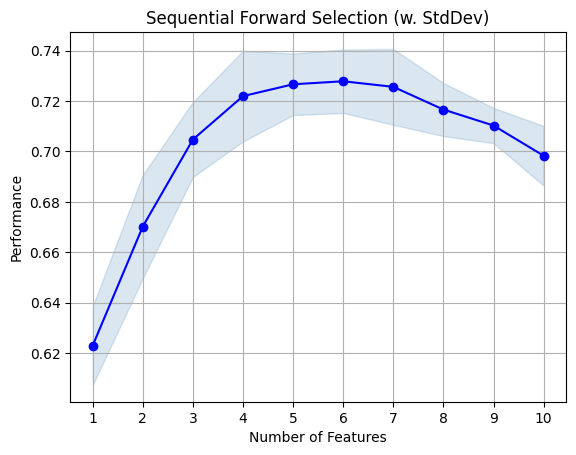

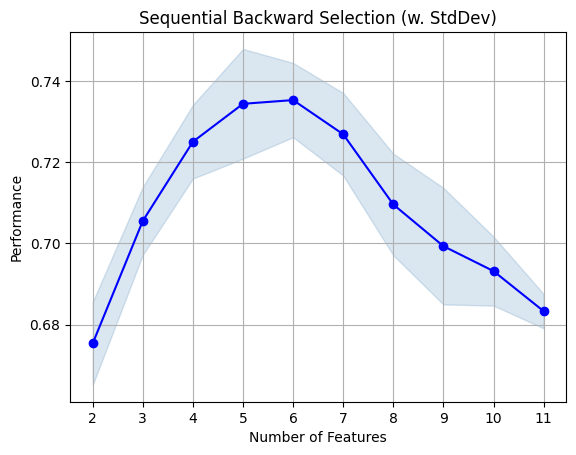

S3UploadFailedError: Failed to upload /home/mle-user/mle_projects/sprint2_ml_ops/fs_assets/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/sbs.csv to s3-student-mle-20241121-3b865ccfbc/8/aaf397d9363e427eb4d6d9f3a97ce0c6/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/df3f11d887034feabf39d5d669895f6c/artifacts/sbs.csv: An error occurred (KeyTooLong) when calling the PutObject operation: Your key is too long.

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.savefig(f"{FS_ASSETS}/sfs.png") 
plt.show()



fig2 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.savefig(f"{FS_ASSETS}/sbs.png") 
plt.show()


interc_features = list(set(top_sbs) & set(top_sfs))

union_features = list(set(top_sbs) | set(top_sfs))




In [57]:
EXPERIMENT_NAME_SFS1 = "Feature_selection_plots_SFS3"
#experiment_id = mlflow.create_experiment(EXPERIMENT_NAME_SFS)
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME_SFS1).experiment_id

with mlflow.start_run(run_name=f"{RUN_NAME}_intersection_and_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifacts(FS_ASSETS) 

In [ ]:
#Байесовский подбор гиперпараметров

from numpy import array, median
from sklearn.base import defaultdict
from sklearn.metrics import confusion_matrix, f1_score, log_loss, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration.mlflow import MLflowCallback
import optuna


EXPERIMENT_NAME = "OPTUNA_PRACTICE_5"# ваш код здесь
RUN_NAME = "model_bayesian_search"

STUDY_DB_NAME = "sqlite:///local.study.db"
STUDY_NAME = "churn_model3"


def objective(trial: optuna.Trial) -> float:
    param = {
   "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
   "depth": trial.suggest_int("depth", 1, 12),
   "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 5),
   "random_strength": trial.suggest_float("random_strength", 0.1, 5),
   "loss_function": "Logloss",
   "task_type": "CPU",
   "random_seed": 0,
   "iterations": 300,
   "verbose": False,
 }
    model1 = CatBoostClassifier(**param)
    skf = StratifiedKFold(n_splits=2)

    metrics = defaultdict(list)
    for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
        train_x = X_train.iloc[train_index]
        train_y = y_train.iloc[train_index]
        val_x = X_train.iloc[val_index]
        val_y = y_train.iloc[val_index]

        model1.fit(val_x, val_y)
        prediction = model1.predict(val_x)
        probas = model1.predict_proba(val_x)[:, 1]
        
        _, err1, _, err2 = confusion_matrix(val_y, prediction, normalize='all').ravel()
        auc = roc_auc_score(val_y, probas)
        precision = precision_score(val_y, prediction)
        recall = recall_score(val_y, prediction)
        f1 = f1_score(val_y, prediction)
        logloss = log_loss(val_y, prediction)
        
        metrics["err1"].append(err1)
        metrics["err2"].append(err2)
        metrics["auc"].append(auc)
        metrics["precision"].append(precision)
        metrics["recall"].append(recall)
        metrics["f1"].append(f1)
        metrics["logloss"].append(logloss)


    # ваш код здесь #
    err_1 = err_1 = median(array(metrics['err1']))
    err_2 = median(array(metrics['err2']))
    auc = median(array(metrics['auc']))
    precision = median(array(metrics['precision']))
    recall = median(array(metrics['recall']))
    f1 = median(array(metrics['f1']))
    logloss = median(array(metrics['logloss']))
    
    #err1 = sum(metrics["err1"]) / len(metrics["err1"])
    #err2 = sum(metrics["err2"]) / len(metrics["err2"])
    #auc = sum(metrics["auc"]) / len(metrics["auc"])
    #precision = sum(metrics["precision"]) / len(metrics["precision"])
    #recall = sum(metrics["recall"]) / len(metrics["recall"])
    #f1 = sum(metrics["f1"]) / len(metrics["f1"])
    #logloss = sum(metrics["logloss"]) / len(metrics["logloss"])
		


    return auc


experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id
    

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as parent_run:
    #run_id = run.info.run_id
    parent_run_id = parent_run.info.run_id

    mlflc = MLflowCallback(
        tracking_uri=f'http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}',
        metric_name='AUC',
        create_experiment=False,
        
        mlflow_kwargs={'experiment_id': experiment_id, 'tags': {"MLFLOW_PARENT_RUN_ID": parent_run_id}, "nested": True, 'parent_run_id': parent_run_id})

    study = optuna.create_study(
            direction="maximize", 
            sampler=optuna.samplers.TPESampler(), 
            storage=STUDY_DB_NAME, 
            study_name=STUDY_NAME,
            load_if_exists=True
            )
    study.optimize(objective, n_trials=10, callbacks=[mlflc])  # 10 trials
    best_params = study.best_params
    model1= CatBoostClassifier(**best_params)
    model1.fit(X_train, y_train)
    mlflow.catboost.log_model(cb_model=model1, artifact_path="some")

print(f"Number of finished trials: {len(study.trials)}")
print(f"Best params: {best_params}")

/tmp/ipykernel_72988/3537952487.py:93: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = MLflowCallback(
[I 2025-01-12 18:26:00,782] Using an existing study with name 'churn_model3' instead of creating a new one.
[I 2025-01-12 18:26:03,981] Trial 61 finished with value: 0.9151343169584361 and parameters: {'learning_rate': 0.05067377494438185, 'depth': 9, 'l2_leaf_reg': 1.8790391572689096, 'random_strength': 1.9845214021712432}. Best is trial 10 with value: 0.915227628174647.


0:	learn: 0.6755355	total: 1.63ms	remaining: 1.63s
1:	learn: 0.6607833	total: 3.4ms	remaining: 1.7s
2:	learn: 0.6266970	total: 8.51ms	remaining: 2.83s
3:	learn: 0.6189091	total: 9.55ms	remaining: 2.38s
4:	learn: 0.6095449	total: 11.2ms	remaining: 2.22s
5:	learn: 0.5817227	total: 16ms	remaining: 2.65s
6:	learn: 0.5750217	total: 18.1ms	remaining: 2.56s
7:	learn: 0.5713684	total: 19.7ms	remaining: 2.44s
8:	learn: 0.5696519	total: 20.6ms	remaining: 2.26s
9:	learn: 0.5667502	total: 22.2ms	remaining: 2.2s
10:	learn: 0.5505398	total: 27.1ms	remaining: 2.44s
11:	learn: 0.5471380	total: 31ms	remaining: 2.55s
12:	learn: 0.5462901	total: 32ms	remaining: 2.43s
13:	learn: 0.5431027	total: 34.3ms	remaining: 2.41s
14:	learn: 0.5416304	total: 35.6ms	remaining: 2.34s
15:	learn: 0.5400973	total: 37.1ms	remaining: 2.28s
16:	learn: 0.5263447	total: 42.2ms	remaining: 2.44s
17:	learn: 0.5251058	total: 43.7ms	remaining: 2.39s
18:	learn: 0.5239894	total: 45.3ms	remaining: 2.34s
19:	learn: 0.5229586	total: 46.